# **Multiclass Classification using Keras and TensorFlow on Food-101 Dataset**
![alt text](https://www.vision.ee.ethz.ch/datasets_extra/food-101/static/img/food-101.jpg)

### **Overview** 
* **Download and extract Food 101 dataset**
* **Understand dataset structure and files** 
* **Visualize random image from each of the 101 classes**
* **Split the image data into train and test using train.txt and test.txt**
* **Create a subset of data with few classes(3) - train_mini and test_mini for experimenting**
* **Fine tune Inception Pretrained model using Food 101 dataset**
* **Visualize accuracy and loss plots**
* **Predicting classes for new images from internet**
* **Scale up and fine tune Inceptionv3 model with 11 classes of data**
* **Model Explainability**
* **Summary of the things I tried**
* **Further improvements**
* **Feedback**

### **Download and extract Food 101 Dataset**

In [29]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [3]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

1.12.0
/device:GPU:0


In [4]:
%cd /kaggle/input/food-101/

/kaggle/input/food-101


In [5]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

* **Commented the below cell as the Food-101 dataset is available from Kaggle Datasets and need not be downloaded..**

In [ ]:
# Download data and extract it to folder
# Uncomment this below line if you are on Colab

#get_data_extract()

### **Understand dataset structure and files**

**The dataset being used is [Food 101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)**
* **This dataset has 101000 images in total. It's a food dataset with 101 categories(multiclass)**
* **Each type of food has 750 training samples and 250 test samples**
* **Note found on the webpage of the dataset :  **  
***On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.***  
* **The entire dataset is 5GB in size**

In [6]:
# Check the extracted dataset folder
!ls food-101/

README.txt  images  license_agreement.txt  meta


**images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class

In [7]:
os.listdir('food-101/images')

['macarons',
 'french_toast',
 'lobster_bisque',
 'prime_rib',
 'pork_chop',
 'guacamole',
 'baby_back_ribs',
 'mussels',
 'beef_carpaccio',
 'poutine',
 'hot_and_sour_soup',
 'seaweed_salad',
 'foie_gras',
 'dumplings',
 'peking_duck',
 'takoyaki',
 'bibimbap',
 'falafel',
 'pulled_pork_sandwich',
 'lobster_roll_sandwich',
 'carrot_cake',
 'beet_salad',
 'panna_cotta',
 'donuts',
 'red_velvet_cake',
 'grilled_cheese_sandwich',
 'cannoli',
 'spring_rolls',
 'shrimp_and_grits',
 'clam_chowder',
 'omelette',
 'fried_calamari',
 'caprese_salad',
 'oysters',
 'scallops',
 'ramen',
 'grilled_salmon',
 'croque_madame',
 'filet_mignon',
 'hamburger',
 'spaghetti_carbonara',
 'miso_soup',
 'bread_pudding',
 'lasagna',
 'crab_cakes',
 'cheesecake',
 'spaghetti_bolognese',
 'cup_cakes',
 'creme_brulee',
 'waffles',
 'fish_and_chips',
 'paella',
 'macaroni_and_cheese',
 'chocolate_mousse',
 'ravioli',
 'chicken_curry',
 'caesar_salad',
 'nachos',
 'tiramisu',
 'frozen_yogurt',
 'ice_cream',
 'ris

**meta** folder contains the text files - train.txt and test.txt  
**train.txt** contains the list of images that belong to training set  
**test.txt** contains the list of images that belong to test set  
**classes.txt** contains the list of all classes of food

In [8]:
os.listdir('food-101/meta')

['test.txt',
 'train.json',
 'labels.txt',
 'test.json',
 'train.txt',
 'classes.txt']

In [9]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [10]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


### **Visualize random image from each of the 101 classes**

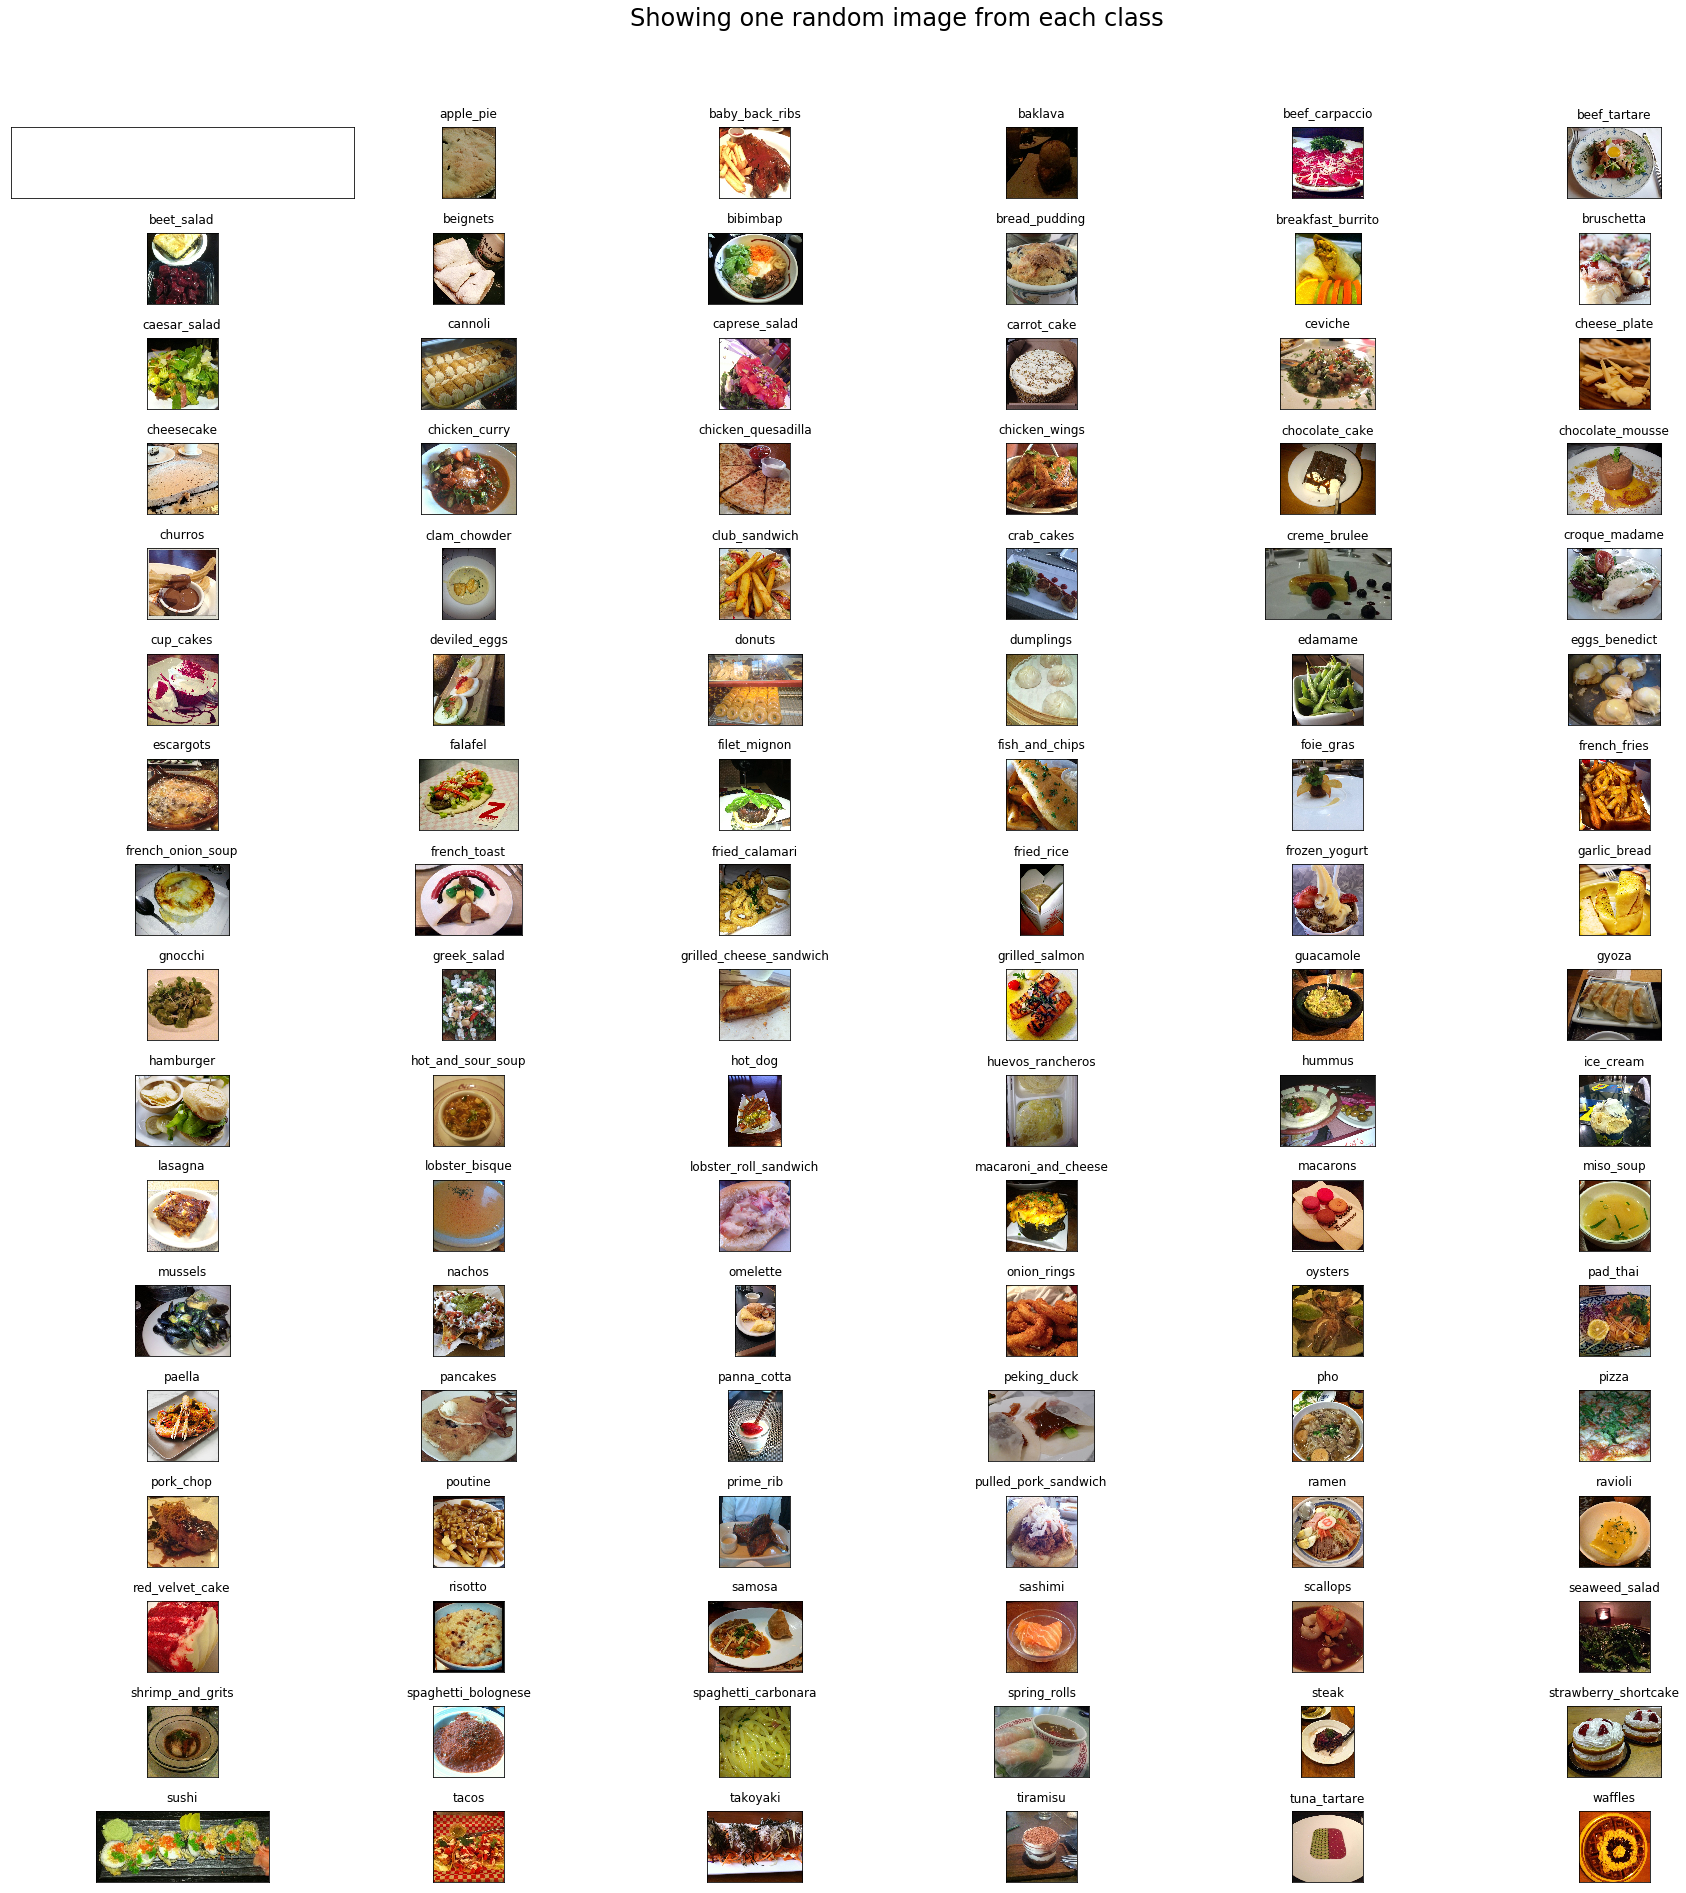

In [11]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


### **Split the image data into train and test using train.txt and test.txt**

In [12]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [13]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('/kaggle/input/food-101/food-101/meta/train.txt', '/kaggle/input/food-101/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [14]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/kaggle/input/food-101/food-101/meta/test.txt', '/kaggle/input/food-101/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [15]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [16]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


### **Create a subset of data with few classes(3) - train_mini and test_mini for experimenting**

* We now have train and test data ready  
* But to experiment and try different architectures, working on the whole data with 101 classes takes a lot of time and computation  
* To proceed with further experiments, I am creating train_min and test_mini, limiting the dataset to 3 classes  
* Since the original problem is multiclass classification which makes key aspects of architectural decisions different from that of binary classification, choosing 3 classes is a good start instead of 2

In [17]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [18]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [19]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [22]:
# picking 51 food items and generating separate data folders for the same
food_list = ['macarons',
 'french_toast',
 'beef_carpaccio',
 'hot_and_sour_soup',
 'seaweed_salad',
 'pulled_pork_sandwich',
 'lobster_roll_sandwich',
 'carrot_cake',
 'red_velvet_cake',
 'grilled_cheese_sandwich',
 'spring_rolls',
 'omelette',
 'fried_calamari',
 'caprese_salad',
 'ramen',
 'grilled_salmon',
 'hamburger',
 'miso_soup',
 'bread_pudding',
 'crab_cakes',
 'cheesecake',
 'cup_cakes',
 'waffles',
 'fish_and_chips',
 'macaroni_and_cheese',
 'chocolate_mousse',
 'chicken_curry',
 'caesar_salad',
 'nachos',
 'frozen_yogurt',
 'ice_cream',
 'club_sandwich',
 'strawberry_shortcake',
 'steak',
 'garlic_bread',
 'chicken_wings',
 'greek_salad',
 'chocolate_cake',
 'samosa',
 'sushi',
 'beef_tartare',
 'apple_pie',
 'pizza',
 'french_onion_soup',
 'hot_dog',
 'chicken_quesadilla',
 'pancakes',
 'fried_rice',
 'cheese_plate',
 'onion_rings',
 'french_fries']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [23]:
len(food_list)

51

In [24]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into macarons
Copying images into french_toast
Copying images into beef_carpaccio
Copying images into hot_and_sour_soup
Copying images into seaweed_salad
Copying images into pulled_pork_sandwich
Copying images into lobster_roll_sandwich
Copying images into carrot_cake
Copying images into red_velvet_cake
Copying images into grilled_cheese_sandwich
Copying images into spring_rolls
Copying images into omelette
Copying images into fried_calamari
Copying images into caprese_salad
Copying images into ramen
Copying images into grilled_salmon
Copying images into hamburger
Copying images into miso_soup
Copying images into bread_pudding
Copying images into crab_cakes
Copying images into cheesecake
Copying images into cup_cakes
Copying images into waffles
Copying images into fish_and_chips
Copying images into macaroni_and_cheese
Copying images into chocolate_mousse
Copying images into chicken_curry
Copying images into caesar_salad
Copying

In [25]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
38250


In [26]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into macarons
Copying images into french_toast
Copying images into beef_carpaccio
Copying images into hot_and_sour_soup
Copying images into seaweed_salad
Copying images into pulled_pork_sandwich
Copying images into lobster_roll_sandwich
Copying images into carrot_cake
Copying images into red_velvet_cake
Copying images into grilled_cheese_sandwich
Copying images into spring_rolls
Copying images into omelette
Copying images into fried_calamari
Copying images into caprese_salad
Copying images into ramen
Copying images into grilled_salmon
Copying images into hamburger
Copying images into miso_soup
Copying images into bread_pudding
Copying images into crab_cakes
Copying images into cheesecake
Copying images into cup_cakes
Copying images into waffles
Copying images into fish_and_chips
Copying images into macaroni_and_cheese
Copying images into chocolate_mousse
Copying images into chicken_curry
Copying images into caesar_salad
Copying 

In [27]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
12750


### **Fine tune Inception Pretrained model using Food 101 dataset**

* Keras and other Deep Learning libraries provide pretrained models  
* These are deep neural networks with efficient architectures(like VGG,Inception,ResNet) that are already trained on datasets like ImageNet  
* Using these pretrained models, we can use the already learned weights and add few layers on top to finetune the model to our new data  
* This helps in faster convergance and saves time and computation when compared to models trained from scratch

* We currently have a subset of dataset with 51 classes 
* Use the below code to finetune InceptionResNetV2 pretrained model

In [32]:
K.clear_session()
n_classes = 51
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionResNetV2(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(51,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_51class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_51class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_51class.hdf5')


Found 38250 images belonging to 51 classes.
Found 12750 images belonging to 51 classes.
Epoch 1/30

Epoch 00001: val_loss improved from inf to 4.32853, saving model to best_model_51class.hdf5
140/140 [==============================] - 308s 2s/step - loss: 4.3511 - acc: 0.0241 - val_loss: 4.3285 - val_acc: 0.0272
Epoch 2/30
139/140 [============================>.] - ETA: 0s - loss: 4.3147 - acc: 0.0211
Epoch 00002: val_loss improved from 4.32853 to 4.30044, saving model to best_model_51class.hdf5
140/140 [==============================] - 97s 690ms/step - loss: 4.3148 - acc: 0.0210 - val_loss: 4.3004 - val_acc: 0.0299
Epoch 3/30
139/140 [============================>.] - ETA: 0s - loss: 4.2856 - acc: 0.0279
Epoch 00003: val_loss improved from 4.30044 to 4.28108, saving model to best_model_51class.hdf5
140/140 [==============================] - 97s 694ms/step - loss: 4.2864 - acc: 0.0277 - val_loss: 4.2811 - val_acc: 0.0367
Epoch 4/30
139/140 [============================>.] - ETA: 0s - 

In [33]:
class_map_51 = train_generator.class_indices
class_map_51

{'apple_pie': 0,
 'beef_carpaccio': 1,
 'beef_tartare': 2,
 'bread_pudding': 3,
 'caesar_salad': 4,
 'caprese_salad': 5,
 'carrot_cake': 6,
 'cheese_plate': 7,
 'cheesecake': 8,
 'chicken_curry': 9,
 'chicken_quesadilla': 10,
 'chicken_wings': 11,
 'chocolate_cake': 12,
 'chocolate_mousse': 13,
 'club_sandwich': 14,
 'crab_cakes': 15,
 'cup_cakes': 16,
 'fish_and_chips': 17,
 'french_fries': 18,
 'french_onion_soup': 19,
 'french_toast': 20,
 'fried_calamari': 21,
 'fried_rice': 22,
 'frozen_yogurt': 23,
 'garlic_bread': 24,
 'greek_salad': 25,
 'grilled_cheese_sandwich': 26,
 'grilled_salmon': 27,
 'hamburger': 28,
 'hot_and_sour_soup': 29,
 'hot_dog': 30,
 'ice_cream': 31,
 'lobster_roll_sandwich': 32,
 'macaroni_and_cheese': 33,
 'macarons': 34,
 'miso_soup': 35,
 'nachos': 36,
 'omelette': 37,
 'onion_rings': 38,
 'pancakes': 39,
 'pizza': 40,
 'pulled_pork_sandwich': 41,
 'ramen': 42,
 'red_velvet_cake': 43,
 'samosa': 44,
 'seaweed_salad': 45,
 'spring_rolls': 46,
 'steak': 47,
 

### **Visualize the accuracy and loss plots**

In [34]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


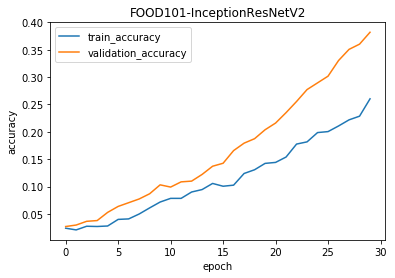

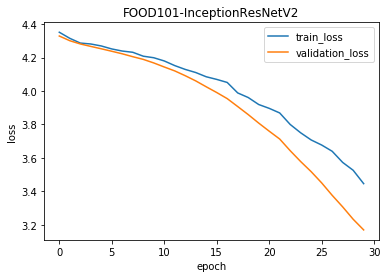

In [35]:
plot_accuracy(history,'FOOD101-InceptionResNetV2')
plot_loss(history,'FOOD101-InceptionResNetV2')

* **The plots show that the accuracy of the model increased with epochs and the loss has decreased**
* **Validation accuracy has been on the higher side than training accuracy for many epochs**
* **This could be for several reasons:**
  * We used a pretrained model trained on ImageNet which contains data from a variety of classes
  * Using dropout can lead to a higher validation accuracy

 


### **Predicting classes for new images from internet using the best trained model**

In [37]:
model_best = load_model('best_model_51class.hdf5',compile = False)

In [40]:
!ls

best_model_51class.hdf5  kaggle			     proc  test
bin			 lib			     root  test_mini
boot			 lib64			     run   tmp
dev			 media			     sbin  train
etc			 mnt			     src   train_mini
history_51class.log	 model_trained_51class.hdf5  srv   usr
home			 opt			     sys   var


In [41]:
! cp best_model_51class.hdf5 /kaggle/working/

In [42]:
model2 = tf.keras.models.load_model('best_model_51class.hdf5')


In [43]:
checkpointer2 = ModelCheckpoint(filepath='2best_model_51class.hdf5', verbose=1, save_best_only=True)
csv_logger2 = CSVLogger('2history_51class.log')

history2 = model2.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger2, checkpointer2])

model2.save('2model_trained_51class.hdf5')

Epoch 1/30
139/140 [============================>.] - ETA: 0s - loss: 3.4041 - acc: 0.2814
Epoch 00001: val_loss improved from inf to 3.09926, saving model to 2best_model_51class.hdf5
140/140 [==============================] - 665s 5s/step - loss: 3.4029 - acc: 0.2807 - val_loss: 3.0993 - val_acc: 0.3859
Epoch 2/30
139/140 [============================>.] - ETA: 0s - loss: 3.3703 - acc: 0.2644
Epoch 00002: val_loss improved from 3.09926 to 3.01680, saving model to 2best_model_51class.hdf5
140/140 [==============================] - 100s 715ms/step - loss: 3.3700 - acc: 0.2643 - val_loss: 3.0168 - val_acc: 0.4022
Epoch 3/30
139/140 [============================>.] - ETA: 0s - loss: 3.2955 - acc: 0.2855
Epoch 00003: val_loss improved from 3.01680 to 2.94826, saving model to 2best_model_51class.hdf5
140/140 [==============================] - 100s 716ms/step - loss: 3.2959 - acc: 0.2853 - val_loss: 2.9483 - val_acc: 0.4198
Epoch 4/30
139/140 [============================>.] - ETA: 0s - loss

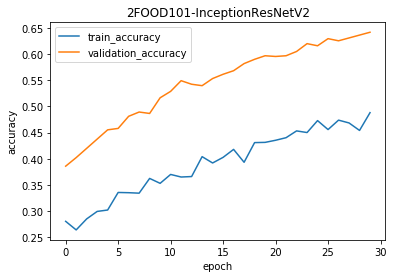

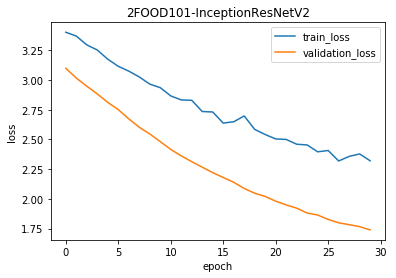

In [45]:
plot_accuracy(history2,'2FOOD101-InceptionResNetV2')
plot_loss(history2,'2FOOD101-InceptionResNetV2')

In [46]:
!ls

2best_model_51class.hdf5     history_51class.log	 opt   test
2history_51class.log	     home			 proc  test_mini
2model_trained_51class.hdf5  kaggle			 root  tmp
best_model_51class.hdf5      lib			 run   train
bin			     lib64			 sbin  train_mini
boot			     media			 src   usr
dev			     mnt			 srv   var
etc			     model_trained_51class.hdf5  sys


In [47]:
! cp 2best_model_51class.hdf5 /kaggle/working/

In [48]:
checkpointer3 = ModelCheckpoint(filepath='3best_model_51class.hdf5', verbose=1, save_best_only=True)
csv_logger3 = CSVLogger('3history_51class.log')

history3 = model2.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=50,
                    verbose=1,
                    callbacks=[csv_logger3, checkpointer3])

model2.save('3model_trained_51class.hdf5')

Epoch 1/50
139/140 [============================>.] - ETA: 0s - loss: 2.2545 - acc: 0.4955
Epoch 00001: val_loss improved from inf to 1.70690, saving model to 3best_model_51class.hdf5
140/140 [==============================] - 103s 733ms/step - loss: 2.2539 - acc: 0.4955 - val_loss: 1.7069 - val_acc: 0.6399
Epoch 2/50
139/140 [============================>.] - ETA: 0s - loss: 2.1946 - acc: 0.5139
Epoch 00002: val_loss improved from 1.70690 to 1.69264, saving model to 3best_model_51class.hdf5
140/140 [==============================] - 100s 715ms/step - loss: 2.1970 - acc: 0.5129 - val_loss: 1.6926 - val_acc: 0.6372
Epoch 3/50
139/140 [============================>.] - ETA: 0s - loss: 2.1954 - acc: 0.5022
Epoch 00003: val_loss improved from 1.69264 to 1.66178, saving model to 3best_model_51class.hdf5
140/140 [==============================] - 99s 704ms/step - loss: 2.1953 - acc: 0.5022 - val_loss: 1.6618 - val_acc: 0.6549
Epoch 4/50
139/140 [============================>.] - ETA: 0s - lo

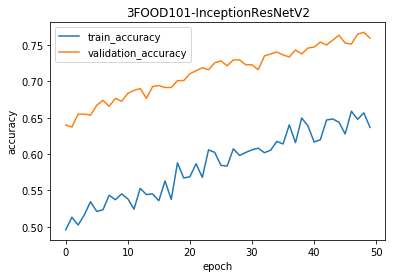

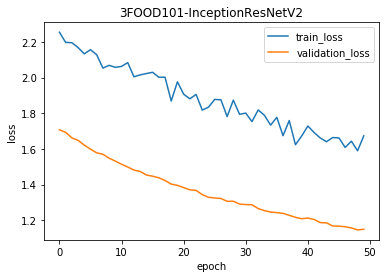

In [49]:
plot_accuracy(history3,'3FOOD101-InceptionResNetV2')
plot_loss(history3,'3FOOD101-InceptionResNetV2')

In [50]:
!ls

2best_model_51class.hdf5     home			 src
2history_51class.log	     kaggle			 srv
2model_trained_51class.hdf5  lib			 sys
3best_model_51class.hdf5     lib64			 test
3history_51class.log	     media			 test_mini
3model_trained_51class.hdf5  mnt			 tmp
best_model_51class.hdf5      model_trained_51class.hdf5  train
bin			     opt			 train_mini
boot			     proc			 usr
dev			     root			 var
etc			     run
history_51class.log	     sbin


In [51]:
! cp 3best_model_51class.hdf5 /kaggle/working/

In [61]:
checkpointer4 = ModelCheckpoint(filepath='4best_model_51class.hdf5', verbose=1, save_best_only=True)
csv_logger4 = CSVLogger('4history_51class.log')


history4 = model2.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=50,
                    verbose=1,
                    callbacks=[csv_logger4, checkpointer4])

model3.save('4model_trained_51class.hdf5')

Epoch 1/50
139/140 [============================>.] - ETA: 0s - loss: 1.5663 - acc: 0.6682
Epoch 00001: val_loss improved from inf to 1.13846, saving model to 4best_model_51class.hdf5
140/140 [==============================] - 105s 753ms/step - loss: 1.5716 - acc: 0.6661 - val_loss: 1.1385 - val_acc: 0.7717
Epoch 2/50
139/140 [============================>.] - ETA: 0s - loss: 1.5909 - acc: 0.6533
Epoch 00002: val_loss improved from 1.13846 to 1.13405, saving model to 4best_model_51class.hdf5
140/140 [==============================] - 102s 730ms/step - loss: 1.5922 - acc: 0.6531 - val_loss: 1.1340 - val_acc: 0.7690
Epoch 3/50
139/140 [============================>.] - ETA: 0s - loss: 1.5573 - acc: 0.6646
Epoch 00003: val_loss improved from 1.13405 to 1.13172, saving model to 4best_model_51class.hdf5
140/140 [==============================] - 102s 728ms/step - loss: 1.5568 - acc: 0.6643 - val_loss: 1.1317 - val_acc: 0.7717
Epoch 4/50
139/140 [============================>.] - ETA: 0s - l

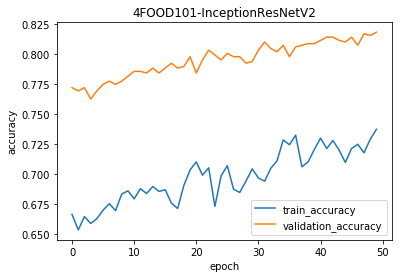

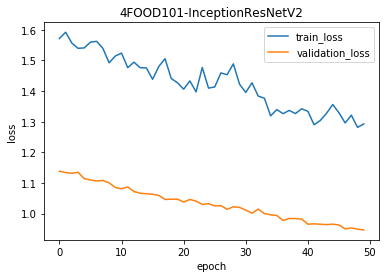

In [62]:
plot_accuracy(history4,'4FOOD101-InceptionResNetV2')
plot_loss(history4,'4FOOD101-InceptionResNetV2')

In [63]:
! cp 4best_model_51class.hdf5 /kaggle/working/

In [68]:
!ls

2best_model_51class.hdf5     etc			 run
2history_51class.log	     history_51class.log	 samosa.jpg
2model_trained_51class.hdf5  home			 sbin
3best_model_51class.hdf5     kaggle			 src
3history_51class.log	     lib			 srv
3model_trained_51class.hdf5  lib64			 sys
4best_model_51class.hdf5     media			 test
4history_51class.log	     mnt			 test_mini
4model_trained_51class.hdf5  model_trained_51class.hdf5  tmp
applepie.jpg		     omelette.jpg		 train
best_model_51class.hdf5      opt			 train_mini
bin			     pizza.jpg			 usr
boot			     proc			 var
dev			     root


In [69]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('4best_model_51class.hdf5',compile = False)

CPU times: user 28.8 s, sys: 808 ms, total: 29.6 s
Wall time: 29.5 s


* **Setting compile=False and clearing the session leads to faster loading of the saved model**
* **Withouth the above addiitons, model loading was taking more than a minute!**

In [70]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [72]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
!wget -O pizza.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Eq_it-na_pizza-margherita_sep2005_sml.jpg/800px-Eq_it-na_pizza-margherita_sep2005_sml.jpg
# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files

# from google.colab import files
# image = files.upload()

--2021-09-04 17:57:35--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 62.75.168.50
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|62.75.168.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K  --.-KB/s    in 0.02s   

2021-09-04 17:57:35 (3.11 MB/s) - ‘samosa.jpg’ saved [75560/75560]

--2021-09-04 17:57:36--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
Connecting to acleanbake.com (acleanbake.com)|138.197.203.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114276 (112K) [image/jpeg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>] 111.60K   403KB/s    in 0.3

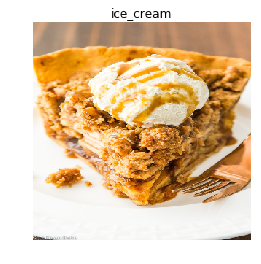

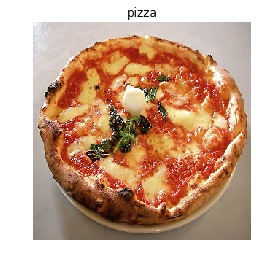

In [73]:
# Make a list of downloaded images and test the trained model
images = []
images.append('applepie.jpg')
images.append('pizza.jpg')
predict_class(model_best, images, True)

* **Summary of the model gives us the list of all the layers in the network along with other useful details**

In [75]:
model_best.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (